In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle
import joblib


datafile = 'Student data.csv'



In [3]:
# read column names
feature_columns = ['First Term Gpa', 'Second Term Gpa',
                   'First Language', 'Funding', 'School',
                   'FastTrack', 'Coop', 'Residency',
                   'Gender', 'Previous Education', 'Age Group',
                   'High School Average Mark', 'Math Score',
                   'English Grade']

target_column = 'FirstYearPersistence'
all_columns = feature_columns + [target_column]

data = pd.read_csv(datafile, skiprows = 24, names=all_columns)

data.describe()


,Funding,School,FastTrack,Coop,Residency,Gender,FirstYearPersistence
count,1434.000000,1434.0,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000
mean,2.928173,6.0,1.741980,1.695955,1.406555,1.774756,0.791492
std,1.257386,0.0,0.437697,0.460162,0.491362,0.419555,0.406383
min,1.000000,6.0,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,6.0,1.000000,1.000000,1.000000,2.000000,1.000000
50%,2.000000,6.0,2.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,6.0,2.000000,2.000000,2.000000,2.000000,1.000000
max,9.000000,6.0,2.000000,2.000000,2.000000,3.000000,1.000000


In [4]:
data.head()

,First Term Gpa,Second Term Gpa,First Language,Funding,School,FastTrack,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
0,3.020833,2.321429,3,4,6,1,2,2,2,2,3,?,?,8,1
1,4.275,4.326923,1,2,6,1,1,1,1,2,3,97,?,9,1
2,4.357143,4.326087,1,2,6,2,1,1,2,2,3,101,45,9,1
3,2.210526,1.375,1,2,6,2,1,1,2,1,1,68,20,7,0
4,2.045455,2.961538,1,2,6,2,1,1,2,1,1,79,34,9,1


In [84]:
print('Number of missing record - ')
for column in data.columns:
    count = (data[column] == "?").sum()
    if count != 0:
        print(f"{column}: {count}")

Number of missing record - 
First Term Gpa: 17
Second Term Gpa: 160
First Language: 111
Previous Education: 4
Age Group: 4
High School Average Mark: 742
Math Score: 461
English Grade: 45


In [3]:
cat_columns = ['First Language', 'Funding', 'School',
               'FastTrack', 'Coop', 'Residency',
               'Gender', 'Previous Education', 'Age Group',
               'English Grade']
num_columns = ['First Term Gpa', 'Second Term Gpa',
                'High School Average Mark', 'Math Score']
columns_to_impute = ['First Term Gpa', 'Second Term Gpa', 'First Language',
                     'Previous Education', 'Age Group', 'High School Average Mark',
                     'Math Score', 'English Grade']

In [4]:
# Replacing Missing Values
meanimputer = SimpleImputer(strategy='mean')
mostfrequentimputer = SimpleImputer(strategy='most_frequent')

data.replace('?', np.nan, inplace=True)

data[num_columns] = meanimputer.fit_transform(data[num_columns])
data[cat_columns] = mostfrequentimputer.fit_transform(data[cat_columns])

In [87]:
data.head()

,First Term Gpa,Second Term Gpa,First Language,Funding,School,FastTrack,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
0,3.020833,2.321429,3,4,6,1,2,2,2,2,3,77.157514,32.56629,8,1
1,4.275000,4.326923,1,2,6,1,1,1,1,2,3,97.000000,32.56629,9,1
2,4.357143,4.326087,1,2,6,2,1,1,2,2,3,101.000000,45.00000,9,1
3,2.210526,1.375000,1,2,6,2,1,1,2,1,1,68.000000,20.00000,7,0
4,2.045455,2.961538,1,2,6,2,1,1,2,1,1,79.000000,34.00000,9,1


In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline([
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

In [60]:
# Combine transformers into a preprocessor
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
        ('num', numerical_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)
    ])

In [61]:
# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [62]:
data = data.astype('float64')

In [63]:
X = data.drop(target_column, axis = 1)
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [67]:
X_train_preprocessed = pipeline.fit(X_train)
X_train_preprocessed = pipeline.transform(X_train)

In [69]:
# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')

# Save the training pipeline
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(X_train_preprocessed.shape[1],)))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(8, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(X_train_preprocessed, y_train, epochs=100, validation_split=0.2)
model.save('project_model.h5')

Epoch 1/100
29/29 [==============================] - 1s 11ms/step - loss: 0.6139 - accuracy: 0.7263 - val_loss: 0.5662 - val_accuracy: 0.8087
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5295 - accuracy: 0.7852 - val_loss: 0.5002 - val_accuracy: 0.8087
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4699 - accuracy: 0.7906 - val_loss: 0.4608 - val_accuracy: 0.8174
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4268 - accuracy: 0.8233 - val_loss: 0.4410 - val_accuracy: 0.8391
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4005 - accuracy: 0.8397 - val_loss: 0.4288 - val_accuracy: 0.8609
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.3841 - accuracy: 0.8408 - val_loss: 0.4199 - val_accuracy: 0.8652
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.3722 - accuracy: 0.8408 - val_loss: 0.4117 - val_accuracy: 0.8652
Epoch 8/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
# Evaluate the model using the validation dataset
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

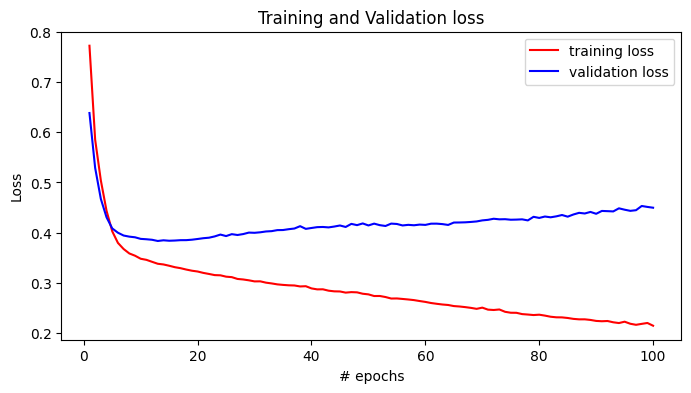

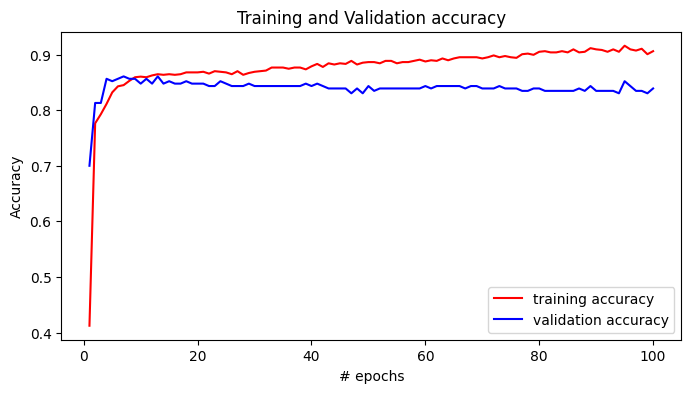

In [67]:
# Plotting the loss on both training and validation
plt.figure(figsize=(8, 4))
plt.plot(epochs, training_loss, 'r', label='training loss')
plt.plot(epochs, validation_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy on both training and validation
plt.figure(figsize=(8, 4))
plt.plot(epochs, training_accuracy, 'r', label='training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [69]:
# Prediction
y_pred = model.predict(X_test_preprocessed)

# Assuming a binary classification with a threshold of 0.5
y_pred_binary = (y_pred > 0.5).astype("int32")

9/9 [==============================] - 0s 13ms/step


In [74]:
pred = model.predict(X_train_preprocessed[0:20])
pred = (pred>0.5).astype("int32")

1/1 [==============================] - 0s 29ms/step


In [75]:
pred

array([[0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 23  37]
 [  6 221]]


In [19]:
# Accuracy Score
acc_score = accuracy_score(y_test, y_pred_binary)
print("Accuracy Score:", acc_score)

Accuracy Score: 0.8501742160278746


In [20]:
# Additional metrics like Precision, Recall, F1-Score
class_report = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.38      0.52        60
         1.0       0.86      0.97      0.91       227

    accuracy                           0.85       287
   macro avg       0.82      0.68      0.71       287
weighted avg       0.84      0.85      0.83       287



In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
